# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing, metrics                                                       # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the images
images = np.load('/content/drive/MyDrive/Colab Notebooks/Project 5/images.npy')

In [4]:
# Load the labels
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project 5/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [5]:
# Print the shape of the images and labels
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


- There are 4750 RGB images, size 128 x 128, with three channels, with corresponding labels.

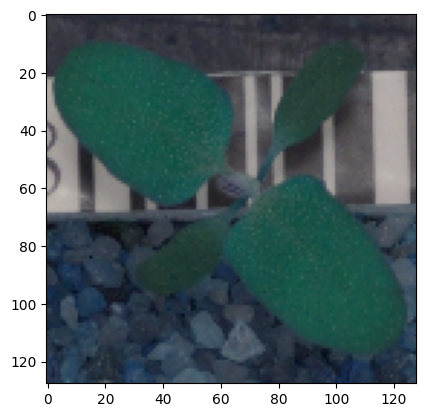

In [6]:
# Show a random image using matplotlib (RGB format)
plt.imshow(images[500])

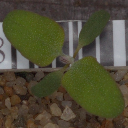

In [7]:
# Show random image using OpenCV (BGR format)
cv2_imshow(images[500])

- It is evident that the images are being shown in different colors (RGB in matplotlib and BGR in OpenCV, respectively)
- Therefore, we must convert the images to RGB format to continue working with them.

### Convert the BGR images to RGB images.

In [8]:
# Converting the images from BGR to RGB
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [9]:
# Define plot_images function
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

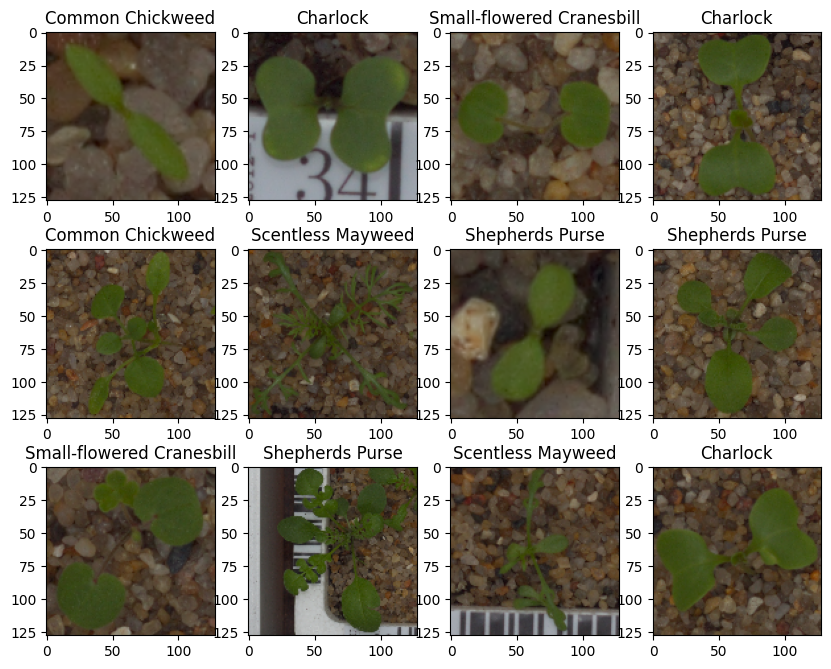

In [10]:
# Plot a chart of images and labels
plot_images(images,labels)

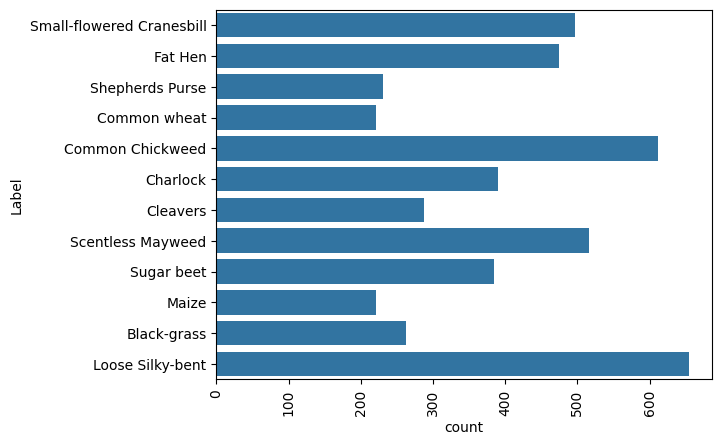

In [11]:
# Print a countplot of labels to check for data imbalance
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')
plt.show()

- The data does not seem to be perfectly balanced, as some categories are far more populated than others. However, there are no categories that have fewer than 200 images,

## Data Pre-Processing

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [12]:
# Decrease the image size to 64x64 pixels
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

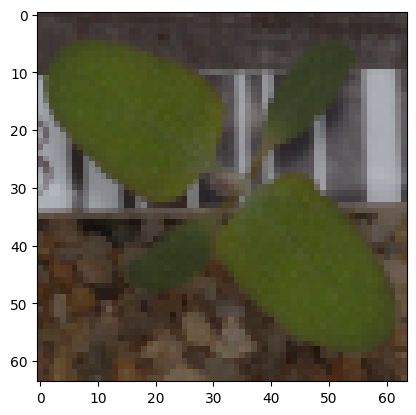

In [13]:
# Plot same random image from earlier in the noteboox to verify decrease
plt.imshow(images_decreased[500])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [14]:
# Split the data into 80% train, 10% validation and 10% test sets
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=1992,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=1/9, random_state=1992,stratify=y_temp)

In [15]:
# Verify the split
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3800, 64, 64, 3) (3800, 1)
(475, 64, 64, 3) (475, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [16]:
# Convert labels from names to onehot vectors
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [17]:
# Verify shape of encoded data
print(y_train_encoded.shape)
print(y_val_encoded.shape)
print(y_test_encoded.shape)

(3800, 12)
(475, 12)
(475, 12)


### Data Normalization

In [18]:
# Normalize the image pixels by scaling
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [19]:
# Clear backend
from tensorflow.keras import backend
backend.clear_session()

In [20]:
# Fix random seed
import random
np.random.seed(1992)
random.seed(1992)
tf.random.set_seed(1992)

In [21]:
# Build initial CNN model using max pooling, batch normalization and dropout layers to prevent overfitting, and a softmax output layer as this is a categorical classification problem
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(12, activation='softmax'))

In [22]:
# Compile model
opt=Adam()
cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Print model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                        

- Initial CNN model has approximately 103,000 trainable parameters.

In [24]:
# Run the model with 50 epochs and a batch size of 32
history_1 = cnn_model.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/50
119/119 - 10s - loss: 2.3132 - accuracy: 0.1813 - val_loss: 2.8332 - val_accuracy: 0.1368 - 10s/epoch - 85ms/step
Epoch 2/50
119/119 - 1s - loss: 1.8135 - accuracy: 0.3653 - val_loss: 6.2164 - val_accuracy: 0.1368 - 934ms/epoch - 8ms/step
Epoch 3/50
119/119 - 1s - loss: 1.5635 - accuracy: 0.4479 - val_loss: 6.5272 - val_accuracy: 0.1368 - 907ms/epoch - 8ms/step
Epoch 4/50
119/119 - 1s - loss: 1.3601 - accuracy: 0.5253 - val_loss: 3.3441 - val_accuracy: 0.1537 - 931ms/epoch - 8ms/step
Epoch 5/50
119/119 - 1s - loss: 1.2019 - accuracy: 0.5800 - val_loss: 2.2551 - val_accuracy: 0.3558 - 915ms/epoch - 8ms/step
Epoch 6/50
119/119 - 1s - loss: 1.0997 - accuracy: 0.6268 - val_loss: 1.4625 - val_accuracy: 0.5663 - 1s/epoch - 9ms/step
Epoch 7/50
119/119 - 1s - loss: 0.9832 - accuracy: 0.6716 - val_loss: 4.1384 - val_accuracy: 0.1558 - 1s/epoch - 10ms/step
Epoch 8/50
119/119 - 1s - loss: 0.8971 - accuracy: 0.6905 - val_loss: 1.1663 - val_accuracy: 0.6295 - 1s/epoch - 10ms/step
Epoch 9

## Model Evaluation

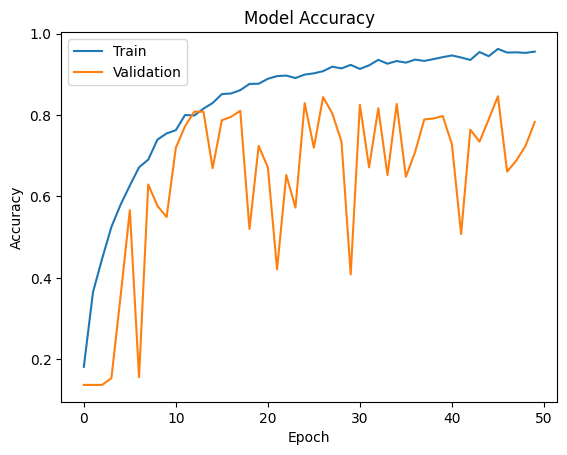

In [25]:
# Plot a graph to evaluate train and validation accuracy on the initial CNN model
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- The accuracy of the initial model is decent to begin with, showing a train accuracy of above 90% and a validation accuracy of around 77%.
- This demonstrates some slight overfitting.

### Evaluate Initial CNN Model on Test Data

In [26]:
accuracy = cnn_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.1289 - accuracy: 0.7979 - 72ms/epoch - 5ms/step


**Plot Confusion Matrix**

In [27]:
# Get output as probabilities for each category
y_pred=cnn_model.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


In [28]:
y_pred

array([[1.39228487e-02, 7.67645496e-13, 2.39253468e-14, ...,
        1.22081006e-15, 1.15702274e-10, 3.05498391e-14],
       [1.36220492e-02, 1.90462143e-11, 1.33499624e-12, ...,
        1.32471006e-13, 2.16692442e-09, 3.59510403e-12],
       [1.65211572e-03, 3.76041158e-14, 8.95483549e-16, ...,
        6.59968037e-17, 4.92247215e-12, 3.25889150e-15],
       ...,
       [2.31956303e-01, 3.98927169e-10, 6.22794524e-11, ...,
        3.57194808e-12, 4.53595348e-08, 8.28566590e-11],
       [1.94405915e-11, 4.81456253e-09, 7.17832449e-07, ...,
        6.28716443e-05, 3.67347952e-09, 1.36664255e-06],
       [3.81603331e-06, 3.60544946e-05, 1.88624545e-04, ...,
        6.22645989e-02, 3.29234899e-05, 5.88984787e-03]], dtype=float32)

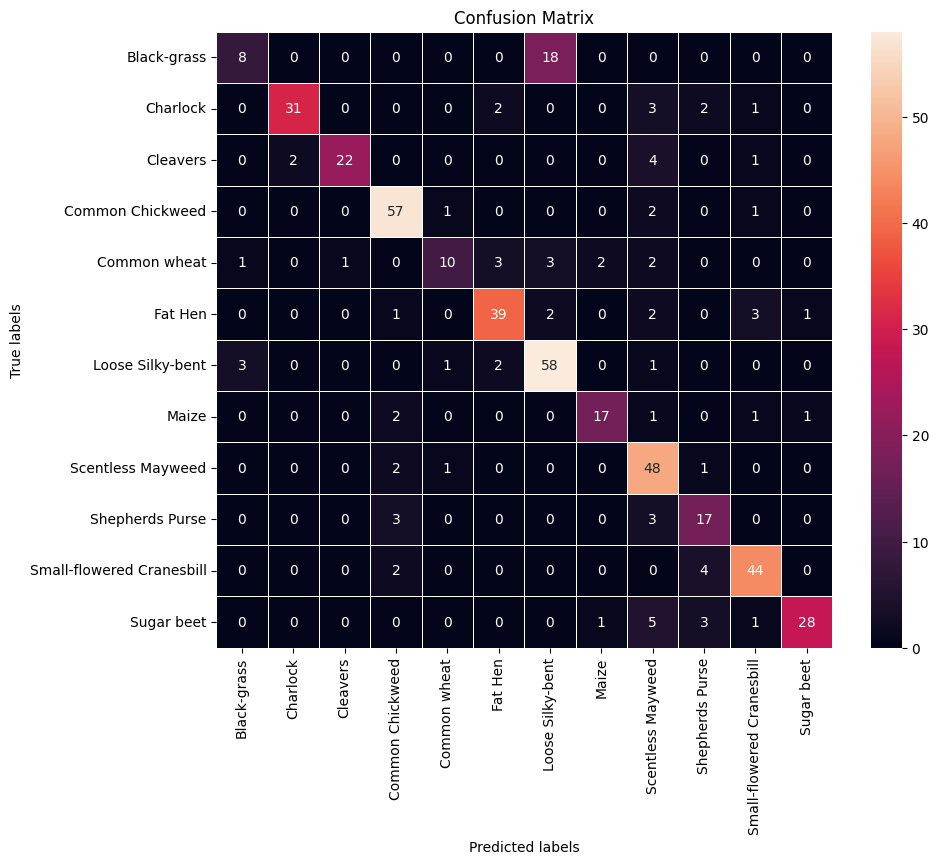

In [29]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
plt.show()

- For the most part, the model did fairly well. The greatest error seems to have come in the classifications for Black-grass being mistaken as Loose Silky-bent and Common Wheat being mistaken for Black Grass.

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [30]:
# Implement a learning rate reduction with LROnPlateau if model val_accuracy stops improving for 5 consecutive epochs
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)


### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [31]:
# Augment image data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    fill_mode='nearest'
)

# Define the ImageDataGenerator for validation and test data with only rescaling
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generate augmented data for training
train_generator = train_datagen.flow(
    X_train, y_train_encoded, batch_size=32
)

# Generate data for validation and testing
val_generator = val_datagen.flow(
    X_val, y_val_encoded, batch_size=32
)
test_generator = test_datagen.flow(
    X_test, y_test_encoded, batch_size=32
)

In [32]:
# Clear backend
from tensorflow.keras import backend
backend.clear_session()

In [33]:
# Fix random seed
import random
np.random.seed(1992)
random.seed(1992)
tf.random.set_seed(1992)

In [34]:
# Import same CNN model used previously
cnn_model_2 = Sequential()
cnn_model_2.add(Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3), padding = 'same'))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(64, activation='relu'))
cnn_model_2.add(Dropout(0.25))
cnn_model_2.add(Dense(32, activation='relu'))
cnn_model_2.add(Dropout(0.25))
cnn_model_2.add(Dense(32, activation='relu'))
cnn_model_2.add(Dense(12, activation='softmax'))

In [35]:
# Compile model
opt=Adam()
cnn_model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Print model summary
cnn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                        

- As this is the same model used previously, and we will only be running augmented images through it, the number of parameters remains the same.

In [37]:
# Fit the model on the augmented data and run it using ReduceLROnPlateau
epochs = 50
batch_size = 32

history_2 = cnn_model_2.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose=2,
    callbacks=[learning_rate_reduction]
)

Epoch 1/50
119/119 - 10s - loss: 2.3425 - accuracy: 0.1632 - val_loss: 2.8122 - val_accuracy: 0.1368 - lr: 0.0010 - 10s/epoch - 81ms/step
Epoch 2/50
119/119 - 5s - loss: 1.8987 - accuracy: 0.3379 - val_loss: 5.6399 - val_accuracy: 0.1368 - lr: 0.0010 - 5s/epoch - 42ms/step
Epoch 3/50
119/119 - 6s - loss: 1.5618 - accuracy: 0.4521 - val_loss: 7.4854 - val_accuracy: 0.1368 - lr: 0.0010 - 6s/epoch - 53ms/step
Epoch 4/50
119/119 - 6s - loss: 1.3742 - accuracy: 0.5184 - val_loss: 1.7421 - val_accuracy: 0.3958 - lr: 0.0010 - 6s/epoch - 48ms/step
Epoch 5/50
119/119 - 5s - loss: 1.2343 - accuracy: 0.5671 - val_loss: 1.2803 - val_accuracy: 0.5663 - lr: 0.0010 - 5s/epoch - 41ms/step
Epoch 6/50
119/119 - 7s - loss: 1.1550 - accuracy: 0.6013 - val_loss: 2.9475 - val_accuracy: 0.1811 - lr: 0.0010 - 7s/epoch - 60ms/step
Epoch 7/50
119/119 - 5s - loss: 1.0587 - accuracy: 0.6318 - val_loss: 1.3360 - val_accuracy: 0.5579 - lr: 0.0010 - 5s/epoch - 42ms/step
Epoch 8/50
119/119 - 6s - loss: 1.0197 - accur

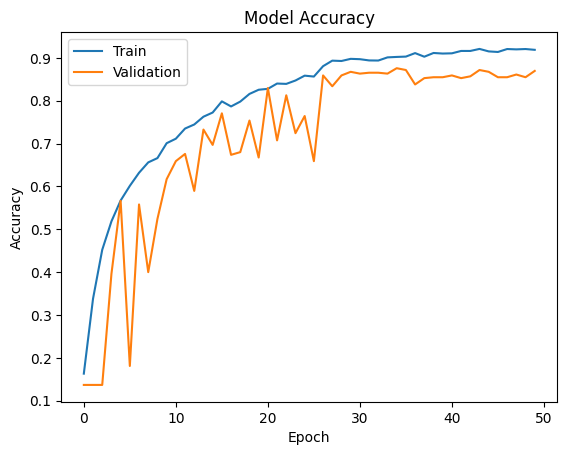

In [38]:
# Plot a graph to evaluate train and validation accuracy on the augmented CNN model
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [39]:
# Evaluate the updated CNN model on test data
accuracy = cnn_model_2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.4028 - accuracy: 0.8716 - 85ms/epoch - 6ms/step


In [40]:
# Get output as probabilities for each category
y_pred=cnn_model_2.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


In [41]:
y_pred

array([[2.83912390e-01, 4.76568784e-12, 1.93210534e-11, ...,
        1.44704897e-12, 1.52583137e-08, 7.45479980e-12],
       [9.85296890e-02, 7.80762011e-13, 8.92917630e-13, ...,
        7.60459079e-13, 4.99223818e-09, 7.53083197e-13],
       [5.73476180e-02, 7.30242086e-16, 2.45149843e-15, ...,
        1.85051539e-16, 9.27753013e-12, 2.42278994e-15],
       ...,
       [3.60935986e-01, 1.01355736e-10, 1.61716651e-09, ...,
        3.14340151e-11, 7.75128584e-08, 5.90702598e-10],
       [3.67795383e-06, 9.72267622e-13, 2.54471910e-09, ...,
        5.98745165e-10, 6.21870422e-09, 3.02822478e-08],
       [6.75317206e-05, 1.18093635e-03, 1.27568066e-01, ...,
        4.17146839e-06, 3.12353455e-04, 8.49130034e-01]], dtype=float32)

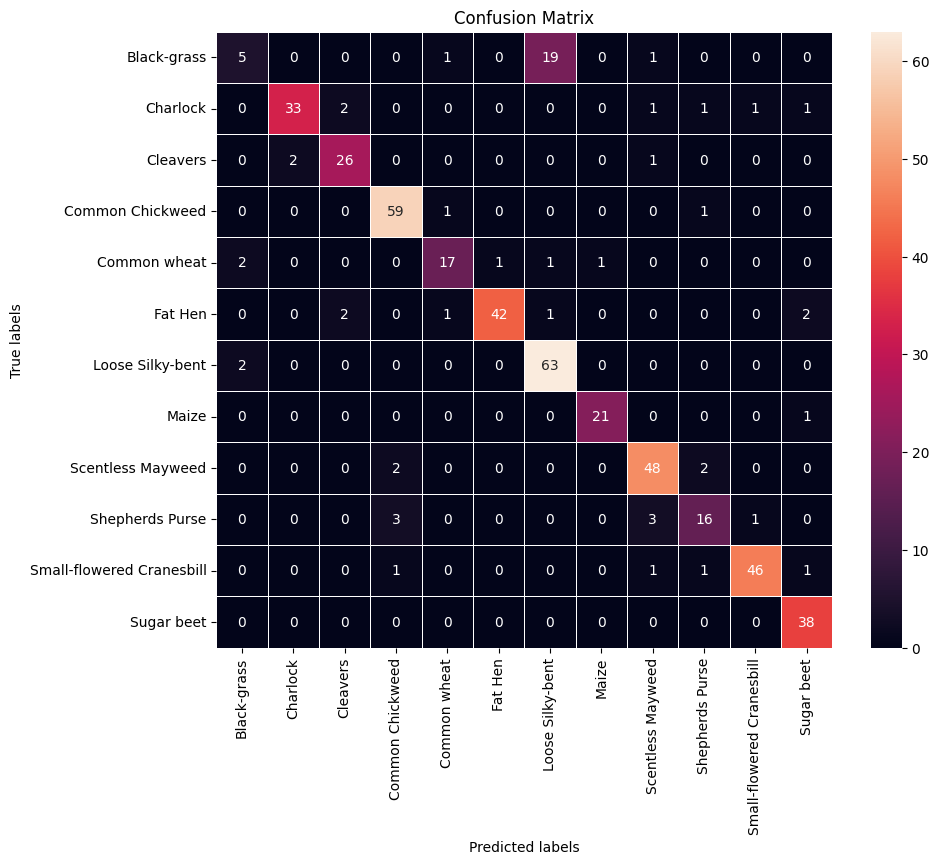

In [42]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
plt.show()

In [43]:
# Print classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.56      0.19      0.29        26
           1       0.94      0.85      0.89        39
           2       0.87      0.90      0.88        29
           3       0.91      0.97      0.94        61
           4       0.85      0.77      0.81        22
           5       0.98      0.88      0.92        48
           6       0.75      0.97      0.85        65
           7       0.95      0.95      0.95        22
           8       0.87      0.92      0.90        52
           9       0.76      0.70      0.73        23
          10       0.96      0.92      0.94        50
          11       0.88      1.00      0.94        38

    accuracy                           0.87       475
   macro avg       0.86      0.83      0.84       475
weighted avg       0.87      0.87      0.86       475



- The updated CNN model with ReducedLROnPlateau and data augmentation improved the validation accuracy by a decent margin, raising it from 77% to 85%.
- Also, the train and validation accuracy scores are far closer than in the previous model, which indicates that the level of overfitting in the updated model has been reduced.

## Final Model

- Between the two models, the second model with data augmentation and learning rate reduction through ReducedLROnPlateau is superior, improving the accuracy on test data by 8%, from 77% to 85%. Therefore, cnn_model_2 is the model that we will proceed with as the final model.

### Visualizing the prediction

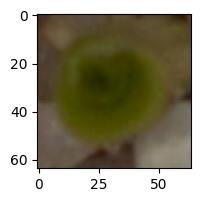

1/1 [==============================] - 0s 269ms/step
Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


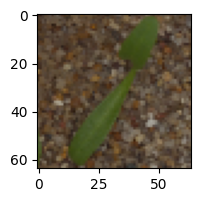

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Maize']
True Label Maize


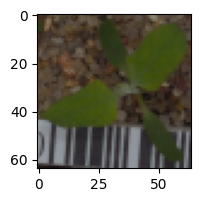

1/1 [==============================] - 0s 25ms/step
Predicted Label ['Sugar beet']
True Label Sugar beet


In [44]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(cnn_model_2.predict((X_test_normalized[2].reshape(1,64,64,3)))))           # reshaping the input image to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                                             # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[66])
plt.show()
print('Predicted Label', enc.inverse_transform(cnn_model_2.predict((X_test_normalized[33].reshape(1,64,64,3)))))           # Repeat on another random image
print('True Label', enc.inverse_transform(y_test_encoded)[33])

plt.figure(figsize=(2,2))
plt.imshow(X_test[99])
plt.show()
print('Predicted Label', enc.inverse_transform(cnn_model_2.predict((X_test_normalized[36].reshape(1,64,64,3)))))          # Repeat on one more random image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Actionable Insights and Business Recommendations

**Conclusions:**

- By implementing the aforementioned model, agricultural firms will be able to differentiate between the 12 different plant seedling species with a reasonably high (~85%) level of accuracy, potentially higher than experienced manual labor.
- If the model is implemented and seedlings are able to be classified accurately, this could potentially lead to increased crop yields and more efficient farming, leading to higher profits for the agricultural firms in question.



**To further increase the accuracy of the model, several steps might be taken in the future:**

- The models could be trained on the original size image (128x128 pixels) rather than the reduced size, which could potentially raise accuracy.
- Changing filter sizes, number of filters, and reworking the dropout, batch normalization and maxpooling layers could also potentially improve model performance.
- In addition to reducing training time, finding an appropriate pre-existing CNN model to implement transfer learning, such as VGG16 or ResNet50, could also improve accuracy and might be a route worth pursuing if further improvement is desired in the future.

_____

In [46]:
# Convert notebook to HTML
!jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/CV_Project_Full_Code_Notebook_LukeCavenderNichols.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/CV_Project_Full_Code_Notebook_LukeCavenderNichols.ipynb to html
[NbConvertApp] Writing 2334934 bytes to /content/drive/MyDrive/Colab Notebooks/CV_Project_Full_Code_Notebook_LukeCavenderNichols.html
